In [1]:
import pickle
import os
from ml_aspade import ml_aspade_train
# from train_eval import preprocess_training_data, train_and_save_model, evaluate_model
from train_eval import train_and_save_model, evaluate_model
from training_data_gen import training_data

# Training Dataset Generation

In [ ]:
# audio_dir = "sounds/Heart_sounds"
# output_path = "training_data"

# target_fs_values = [2000]
# clipping_thresholds = [0.15]
# time_clip = [1]

# # Run training pipeline
# training_data = training_data(
#     audio_dir=audio_dir,
#     output_path=output_path,
#     target_fs_values=target_fs_values,
#     clipping_thresholds=clipping_thresholds,
#     time_clip=time_clip
# )

# # Save using pickle
# with open(os.path.join(output_path, 'training_data.pkl'), 'wb') as f:
#     pickle.dump(training_data, f)    

# Training


Starting model training...
Number of training samples: 1710
Initializing ML engine...
Input dimension: 2000, Output dimension: 2000
Epoch 2000/2000 | Loss: 0.3244 | Est: 0.3244 | Spar: 0.0000 | Acc: 100.00%
Training complete.


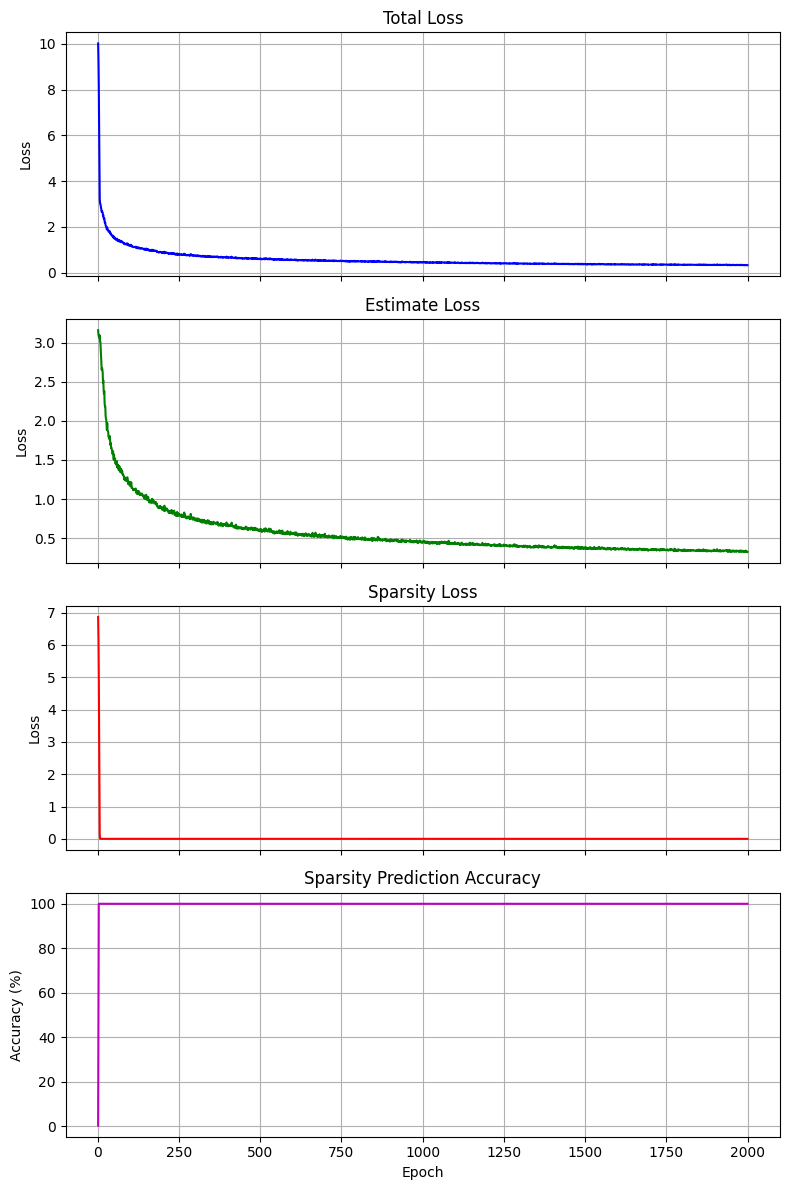

Model Saved


In [2]:
output_path = "training_data"
model_path = "sparsity_model.pth"
k_classes = 1000
# Using pickle
with open(os.path.join(output_path, 'training_data.pkl'), 'rb') as f:
    training_data = pickle.load(f)


# Train the model
print("\nStarting model training...")
print(f"Number of training samples: {len(training_data)}")

print("Initializing ML engine...")

# X_train, y_train, k_train = preprocess_training_data(training_data)

# # Example usage
# model = train_and_save_model(X_train, y_train, k_train, model_path, k_classes, num_epochs=1000, lr=1e-3)

# print("Model Saved")
# Train directly with the training data
model = train_and_save_model(training_data, model_path, num_epochs=2000, lr=1e-3, batch_size=512)
print("Model Saved")


# Evaluation

Evaluating configurations:   0%|          | 0/1 [00:00<?, ?it/s]


Processing: sound1.wav
Generating clipped signal...


/data2/AAG/MTech_Project/spade_segmentation.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  data_rec_fin[idx] = data_rec_fin[idx] + data_rec_block * gsyn
Processing: 100%|██████████| 19/19 [00:02<00:00,  8.20iteration/s]


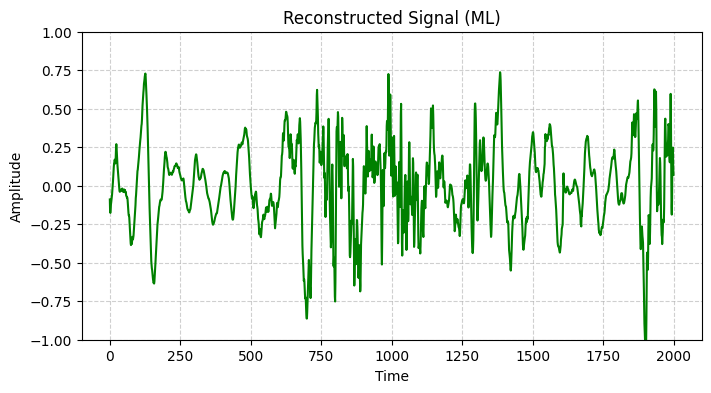

Evaluating configurations: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it]



Evaluation Summary:
                        sdr_improvement     processing_time clipped_percentage
                                   mean std            mean               mean
fs   threshold duration                                                       
2000 0.15      1                   4.42 NaN            2.32               52.5


In [3]:
sparsity_model_path = "sparsity_model.pth"
test_audio_dir = "test_data"
output_dir = "/data2/AAG/MTech_Project"

target_fs_values = [2000]
clipping_thresholds = [0.15]
time_clip = [1]
k_classes = 1000

# Run evaluation
results_df, summary = evaluate_model(
    test_audio_dir=test_audio_dir,
    output_dir=output_dir,
    target_fs_values=target_fs_values,
    clipping_thresholds=clipping_thresholds,
    time_clip=time_clip,
    model_path=sparsity_model_path,
    k_classes=k_classes)

# Print summary statistics
print("\nEvaluation Summary:")
print(summary)


# EXTRAS

In [ ]:
# # Set the model to evaluation mode
# ml_engine.sparsity_predictor.eval()

# # Prepare the input (ensure it is a torch.Tensor and has the correct shape)
# input_tensor = torch.FloatTensor(training_data[0][0]).to(ml_engine.device)

# # Add a batch dimension if the input is 1D (shape: [4000] -> [1, 4000])
# input_tensor = input_tensor.unsqueeze(0)

# # Perform inference
# with torch.no_grad():  # Disable gradient computation for inference
#     output = ml_engine.sparsity_predictor(input_tensor)

# print("Predicted sparsity:", output.item())


Layer: network.0.weight
Shape: (128, 4000)
Parameters: 512000
Mean: -0.004790
Std: 0.010169
Min: -0.107086
Max: 0.082124

Layer: network.0.bias
Shape: (128,)
Parameters: 128
Mean: -0.003822
Std: 0.010131
Min: -0.024671
Max: 0.034027

Layer: network.3.weight
Shape: (64, 128)
Parameters: 8192
Mean: -0.002041
Std: 0.051029
Min: -0.177001
Max: 0.101418

Layer: network.3.bias
Shape: (64,)
Parameters: 64
Mean: 0.037031
Std: 0.158217
Min: -0.188847
Max: 0.563376

Layer: network.5.weight
Shape: (1, 64)
Parameters: 64
Mean: -0.003996
Std: 0.057658
Min: -0.184444
Max: 0.112050

Layer: network.5.bias
Shape: (1,)
Parameters: 1
Mean: -0.021527
Std: nan
Min: -0.021527
Max: -0.021527

Model Summary:
Total Parameters: 520449
Number of Layers: 6


/tmp/ipykernel_4051924/3545444097.py:30: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  'std': float(tensor.std()),


NameError: name 'plt' is not defined

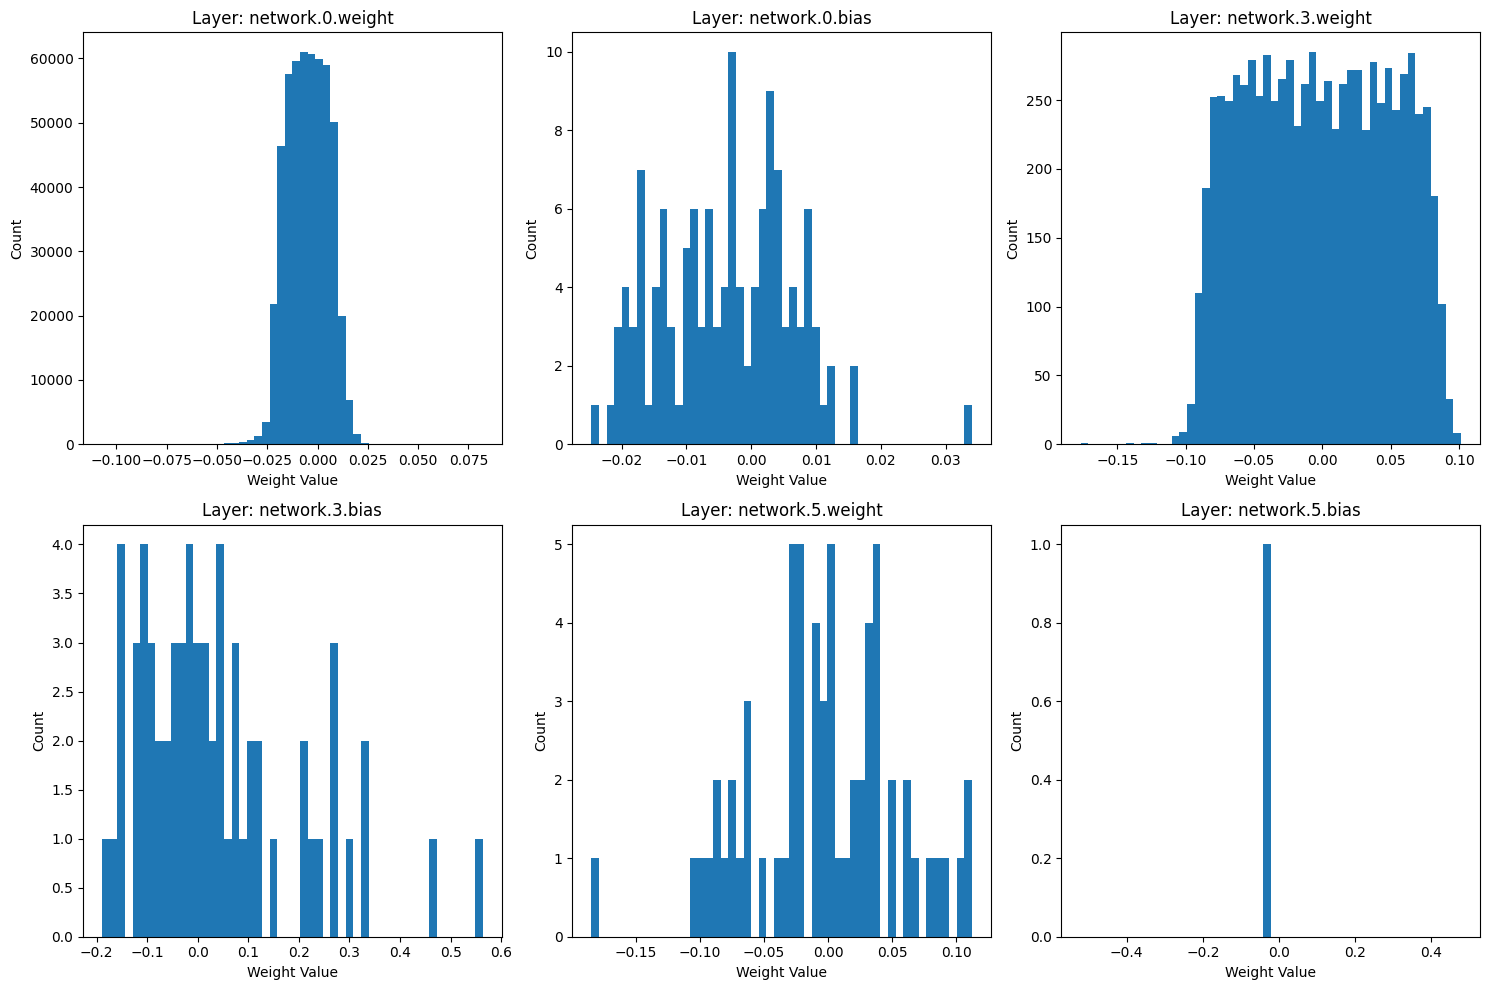

In [6]:
import torch
import numpy as np
from typing import Dict
from collections import OrderedDict

def inspect_model_weights(model_path: str, detailed: bool = False) -> Dict:
    """
    Load and inspect weights from a saved PyTorch model
    
    Parameters:
    -----------
    model_path : str
        Path to the .pth file
    detailed : bool
        If True, prints detailed statistics for each layer
        
    Returns:
    --------
    Dict containing weight statistics
    """
    # Load the state dict
    state_dict = torch.load(model_path)
    
    weights_info = OrderedDict()
    
    def analyze_tensor(tensor: torch.Tensor) -> Dict:
        return {
            'shape': tuple(tensor.shape),
            'mean': float(tensor.mean()),
            'std': float(tensor.std()),
            'min': float(tensor.min()),
            'max': float(tensor.max()),
            'num_params': tensor.numel()
        }
    
    total_params = 0
    
    # Analyze each layer
    for name, param in state_dict.items():
        weights_info[name] = analyze_tensor(param)
        total_params += param.numel()
        
        if detailed:
            print(f"\nLayer: {name}")
            print(f"Shape: {weights_info[name]['shape']}")
            print(f"Parameters: {weights_info[name]['num_params']}")
            print(f"Mean: {weights_info[name]['mean']:.6f}")
            print(f"Std: {weights_info[name]['std']:.6f}")
            print(f"Min: {weights_info[name]['min']:.6f}")
            print(f"Max: {weights_info[name]['max']:.6f}")
    
    # Add summary statistics
    weights_info['summary'] = {
        'total_parameters': total_params,
        'num_layers': len(state_dict)
    }
    
    return weights_info

# Function to visualize weight distributions
def plot_weight_distributions(model_path: str):
    """
    Create histograms of weight distributions for each layer
    """
    import matplotlib.pyplot as plt
    
    state_dict = torch.load(model_path)
    num_layers = len(state_dict)
    
    # Calculate grid dimensions
    cols = min(3, num_layers)
    rows = (num_layers + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1 or cols == 1:
        axes = axes.reshape(-1, 1) if cols == 1 else axes.reshape(1, -1)
    
    for idx, (name, param) in enumerate(state_dict.items()):
        row = idx // cols
        col = idx % cols
        
        weights = param.cpu().numpy().flatten()
        axes[row, col].hist(weights, bins=50)
        axes[row, col].set_title(f'Layer: {name}')
        axes[row, col].set_xlabel('Weight Value')
        axes[row, col].set_ylabel('Count')
    
    plt.tight_layout()
    return fig

# Example usage:
if __name__ == "__main__":
    # Replace with your model path
    model_path = "/mnt/External/8TBHDD/AAG/MTech_Project/diff_sdr/heart/sampling/sparsity_predictor.pth"
    
    # Get weight statistics
    stats = inspect_model_weights(model_path, detailed=True)
    
    print("\nModel Summary:")
    print(f"Total Parameters: {stats['summary']['total_parameters']}")
    print(f"Number of Layers: {stats['summary']['num_layers']}")
    
    # Plot weight distributions
    fig = plot_weight_distributions(model_path)
    plt.show()

In [ ]:
# import numpy as np
# import torch
# import soundfile as sf
# from scipy.signal import resample
# import os
# from typing import Dict, List
# import matplotlib.pyplot as plt
# from tqdm import tqdm
# import pandas as pd
# from gabwin import gabwin
# from gabdual import gabdual
# from peak_normalize import peak_normalize



# def spade_segmentation_eval(clipped_signal, resampled_data, Ls, win_len, win_shift, ps_maxit, ps_epsilon, ps_r, ps_s, F_red, masks, ml_engine):

#   win_len = int(win_len)
#   win_shift = int(win_shift)
#   # Implement the SPADE algorithm for reconstruction
#   L = int(np.ceil(Ls / win_shift) * win_shift + (np.ceil(win_len / win_shift) - 1) * win_shift) # L is divisible by a and minimum amount of zeros equals gl (window length). Zeros will be appended to avoid periodization of nonzero samples.
#   N = L // win_shift

#   # padding the signals and masks to length L
#   padding = np.zeros(int(L - Ls))
#   data_clipped = np.concatenate([clipped_signal, padding])
#   data_orig = np.concatenate([resampled_data, padding])
#   masks['Mr'] = np.concatenate([masks['Mr'], np.ones(int(L - Ls), dtype=bool)])
#   masks['Mh'] = np.concatenate([masks['Mh'], np.zeros(int(L - Ls), dtype=bool)])
#   masks['Ml'] = np.concatenate([masks['Ml'], np.zeros(int(L - Ls), dtype=bool)])

#   # Construction of analysis and synthesis windows
#   g = gabwin(win_len)
#   gana = peak_normalize(g)  # Peak-normalization of the analysis window
#   gsyn = gabdual(gana, win_shift, win_len) * win_len  # Computing the synthesis window

#   # This is substituting fftshift (computing indexes to swap left and right half of the windows)
#   idxrange = np.concatenate([np.arange(0, np.ceil(win_len / 2)), np.arange(-np.floor(win_len / 2), 0)])
#   idxrange2 = idxrange + abs(np.min(idxrange))

#   # Convert the float array to integer array
#   idxrange = idxrange.astype(int)
#   idxrange2 = idxrange2.astype(int)

#   # Initialization of signal blocks
#   data_block = np.zeros(win_len)
#   data_orig_block = np.zeros(win_len)
#   data_rec_fin = np.zeros(L)

#   # initialization of parameters for one signal block
#   ps_Ls = win_len
#   masks_seg = {
#     'Mr': np.ones(win_len).astype(bool),
#     'Mh': np.zeros(win_len).astype(bool),
#     'Ml': np.zeros(win_len).astype(bool)
#   }

#   # Main loop
#   for n in tqdm(range(N), desc="Processing", unit="iteration"):
#     # multiplying signal block with windows and choosing corresponding masks
#     idx = np.mod(n * win_shift + idxrange, L)
#     idx = idx.astype(int)
#     data_block[idxrange2] = data_clipped[idx] * gana
#     data_orig_block[idxrange2] = data_orig[idx] * gana

#     assert len(masks['Mr']) > np.max(idx), "Index 'idx' exceeds masks['Mr'] dimensions"
#     assert len(masks_seg['Mr']) > np.max(idxrange2), "Index 'idxrange2' exceeds masks_seg['Mr'] dimensions"

#     masks_seg['Mr'][idxrange2] = masks['Mr'][idx]
#     masks_seg['Mh'][idxrange2] = masks['Mh'][idx]
#     masks_seg['Ml'][idxrange2] = masks['Ml'][idx]

#     data_rec_block = ml_aspade_eval(data_block, masks_seg, ps_Ls, ps_maxit, ps_epsilon, ps_r, ps_s,F_red, ml_engine)
#     # # Assuming you have the `metrics` dictionary with the required histories
#     # sparsity_history = metrics['sparsity_history']
#     # objective_history = metrics['objective_history']

#     # # Print the entire sparsity history and objective history
#     # print("Sparsity History:")
#     # print(sparsity_history)

#     # print("\nObjective History:")
#     # print(objective_history)

#     # Folding blocks together using Overlap-Add approach (OLA)
#     data_rec_block = np.fft.ifftshift(data_rec_block)
#     data_rec_fin[idx] = data_rec_fin[idx] + data_rec_block * gsyn

#   data_rec_fin = data_rec_fin[:Ls]

#   return data_rec_fin


# # Evaluation version (original function with minor modifications)
# def ml_aspade_eval(data_clipped: np.ndarray,
#                    masks: np.ndarray,
#                    Ls: int,
#                    max_it: int,
#                    epsilon: float,
#                    r: int,
#                    s: int,
#                    redundancy: float,
#                    ml_engine) -> Tuple[np.ndarray, dict]:
#     """
#     ML-ASPADE evaluation version that uses trained models
    
#     Parameters:
#     -----------
#     (same as original)
    
#     Returns:
#     --------
#     Tuple containing:
#     - Reconstructed signal
#     - Performance metrics
#     """
#     # (Original implementation remains largely the same)
#     # The key difference is this version uses the trained ml_engine
#     # and doesn't collect training data
    
#     max_it = int(max_it)
#     x_hat = np.copy(data_clipped)
#     zEst = frana(x_hat, redundancy)
#     u = np.zeros(len(zEst), dtype=complex)
#     cnt = 1
#     bestObj = float('inf')
    
#     current_features = torch.FloatTensor(np.abs(zEst)).to(ml_engine.device)
    

#     with torch.no_grad():
#         #k = int(ml_engine.sparsity_predictor(current_features).item() * len(zEst))
#         k = int(ml_engine.sparsity_predictor(current_features).item() * len(zEst))
#         k = max(s, min(k, len(zEst) // 2))
#         k=1000
#         #print("predicted k: %d",k)
    
#     # Dynamic sparsity parameters
#     obj_his = np.zeros((3,1))   # Store last 3 objective values
#     imp_thres = 1e-4    # Minimum improvement threshold
#     max_sparsity = len(zEst) * 0.5  # Maximum sparsity limit (50% of coefficients)

#     # sdr_iter = np.full((max_it, 1), np.nan)
#     # obj_iter = np.full((max_it, 1), np.nan)

#     while cnt <= max_it:
#         # set all but k largest coefficients to zero (complex conjugate pairs are taken into consideration)
#         z_bar = hard_thresholding(zEst + u, k)

#         objVal = np.linalg.norm(zEst - z_bar)  # update termination function

#         # Store objective value history
#         obj_his = np.roll(obj_his, 1)
#         obj_his[0] = objVal
        
#         if objVal <= bestObj:
#             data_rec = x_hat
#             bestObj = objVal

#         # Dynamic sparsity update based on convergence behavior

#         if cnt > 3:
#             rel_improvement = (obj_his[2] - objVal) / obj_his[2]    # Calculate relative improvement
            
#             if rel_improvement < imp_thres:
#                 k = min(k + 2 * s, max_sparsity)    # Slow convergence - increase sparsity more aggressively
#             elif rel_improvement > 5 * imp_thres:
#                 k = k   # Fast convergence - maintain current sparsity
#             else:
#                 if cnt % r == 0:
#                     k = min(k + s, max_sparsity)

#         adap_epsilon = epsilon * (1 + 0.1 * np.log(cnt))    # termination step with adaptive threshold

#         if objVal <= adap_epsilon:
#             break

#         # projection onto the set of feasible solutions    
#         b = z_bar - u
#         syn = frsyn(b, redundancy)
#         syn = syn[:Ls]
#         x_hat = proj_time(syn, masks, data_clipped)
        
#         # Store SDR or obj if needed (uncomment if required)
#         # if paramsolver.store_sdr:
#         #     sdr_iter[cnt] = sdr(data_orig, x_hat)
#         # if paramsolver.store_obj:
#         #     obj_iter[cnt] = objVal
        
#         # dual variable update
#         zEst = frana(x_hat, redundancy)
#         u = u + zEst - z_bar
        
#         cnt += 1    # iteration counter update
    
#     print("Objval: %d", objVal)
    
#     print("final k: %d",k)

#     return x_hat

# def evaluate_model(ml_engine,
#                   test_audio_dir: str,
#                   output_dir: str,
#                   target_fs_values: List[int],
#                   clipping_thresholds: List[float],
#                   time_clip: List[int]) -> Dict:
#     """
#     Evaluate trained ASPADE model on test audio files
    
#     Parameters:
#     -----------
#     model_path : str
#         Path to trained model
#     test_audio_dir : str
#         Directory containing test audio files
#     output_dir : str
#         Directory to save reconstructed audio and results
#     target_fs_values : List[int]
#         List of sampling frequencies to test
#     clipping_thresholds : List[float]
#         List of clipping thresholds to test
#     time_clip : List[int]
#         List of time durations to test
#     """
#     # # Load trained model
#     # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     # ml_engine = MLEnhancedASPADE(signal_dim=4000)  # Adjust signal_dim as needed
#     # ml_engine.load_state_dict(torch.load(model_path))
#     # ml_engine.to(device)
#     # ml_engine.eval()
    
#     # Create output directory
#     os.makedirs(output_dir, exist_ok=True)
    
#     # Initialize results storage
#     results = {
#         'file': [],
#         'fs': [],
#         'threshold': [],
#         'duration': [],
#         'sdr_original': [],
#         'sdr_reconstructed': [],
#         'sdr_improvement': [],
#         'processing_time': [],
#         'clipped_percentage': []
#     }
    
#     # Process each configuration
#     total_configs = len(target_fs_values) * len(clipping_thresholds) * len(time_clip)
#     pbar = tqdm(total=total_configs, desc="Evaluating configurations")
    
#     for target_fs in target_fs_values:
#         for clipping_threshold in clipping_thresholds:
#             dir_name = f"fs_{target_fs}_threshold_{clipping_threshold:.2f}"
#             full_dir_path = os.path.join(output_dir, dir_name)
#             os.makedirs(full_dir_path, exist_ok=True)

#             for tc in time_clip:
#                 wav_files = [f for f in os.listdir(test_audio_dir) if f.endswith(".wav")]
#                 n_files = 1  # Process one file as specified
#                 wav_files = wav_files[:n_files]
                
#                 for audio_file in wav_files:
#                     print(f"\nProcessing: {audio_file}")
                    
#                     # Load and preprocess audio
#                     data, fs = sf.read(os.path.join(test_audio_dir, audio_file))
                    
#                     if len(data.shape) > 1:
#                         data = data[:, 0]
                    
#                     # Clip to desired duration and normalize
#                     data = data[:fs * tc]
#                     data = data / np.max(np.abs(data))
                    
#                     # Resample to target frequency
#                     resampled_data = resample(data, int(target_fs * tc))

#                     # Setup parameters
#                     Ls = len(resampled_data)
#                     win_len = np.floor(Ls/2)
#                     win_shift = np.floor(win_len/4)
#                     F_red = 2
                    
#                     # ASPADE parameters
#                     ps_s = 1
#                     ps_r = 2
#                     ps_epsilon = 0.1
#                     ps_maxit = np.ceil(np.floor(win_len * F_red / 2 + 1) * ps_r / ps_s)
                    
#                     # Generate clipped signal
#                     print("Generating clipped signal...")
                    
#                     # Generate clipped signal
#                     clipped_signal, masks, theta, sdr_original, clipped_percentage = \
#                         clip_sdr_modified(resampled_data, clipping_threshold)
                    
#                     # Perform reconstruction
#                     start_time = time()
#                     reconstructed_signal = spade_segmentation_eval(
#                         clipped_signal, resampled_data, Ls, win_len, win_shift,
#                         ps_maxit, ps_epsilon, ps_r, ps_s, F_red, masks, ml_engine
#                     )
#                     processing_time = time() - start_time

#                     # Calculate metrics
#                     sdr_reconstructed = sdr(resampled_data, reconstructed_signal)
#                     sdr_improvement = sdr_reconstructed - sdr_original
                    
#                     # Save reconstructed audio
#                     output_path = os.path.join(full_dir_path, f"reconstructed_{audio_file}")
#                     sf.write(output_path, reconstructed_signal, target_fs)
                    
#                     # Store results
#                     results['file'].append(audio_file)
#                     results['fs'].append(target_fs)
#                     results['threshold'].append(clipping_threshold)
#                     results['duration'].append(tc)
#                     results['sdr_original'].append(sdr_original)
#                     results['sdr_reconstructed'].append(sdr_reconstructed)
#                     results['sdr_improvement'].append(sdr_improvement)
#                     results['processing_time'].append(processing_time)
#                     results['clipped_percentage'].append(clipped_percentage)
                    
#                     plt.plot(reconstructed_signal)
#                     # # Save visualization
#                     # plt.figure(figsize=(15, 10))
                    
#                     # plt.subplot(311)
#                     # plt.plot(resampled_data)
#                     # plt.title('Original Signal')
#                     # plt.grid(True)
                    
#                     # plt.subplot(312)
#                     # plt.plot(clipped_signal)
#                     # plt.title('Clipped Signal')
#                     # plt.grid(True)
                    
#                     # plt.subplot(313)
#                     # plt.plot(reconstructed_signal)
#                     # plt.title('Reconstructed Signal')
#                     # plt.grid(True)
                    
#                     # plt.tight_layout()
#                     # plt.savefig(os.path.join(full_dir_path, f"visualization_{audio_file[:-4]}.png"))
#                     # plt.close()
                
#                 pbar.update(1)
    
#     pbar.close()
    
#     # Convert results to DataFrame and save
#     results_df = pd.DataFrame(results)
#     # results_df.to_csv(os.path.join(output_dir, 'evaluation_results.csv'), index=False)
    
#     # Generate summary statistics
#     summary = results_df.groupby(['fs', 'threshold', 'duration']).agg({
#         'sdr_improvement': ['mean', 'std'],
#         'processing_time': 'mean',
#         'clipped_percentage': 'mean'
#     }).round(2)
    
#     # summary.to_csv(os.path.join(output_dir, 'summary_statistics.csv'))
    
#     # # Plot summary results
#     # plt.figure(figsize=(12, 8))
    
#     # plt.subplot(211)
#     # for fs in target_fs_values:
#     #     data = results_df[results_df['fs'] == fs]
#     #     plt.scatter(data['threshold'], data['sdr_improvement'], 
#     #                label=f'fs={fs}', alpha=0.6)
    
#     # plt.xlabel('Clipping Threshold')
#     # plt.ylabel('SDR Improvement (dB)')
#     # plt.legend()
#     # plt.grid(True)
#     # plt.title('SDR Improvement vs Clipping Threshold')
    
#     # plt.subplot(212)
#     # plt.boxplot([results_df[results_df['fs'] == fs]['sdr_improvement'] 
#     #              for fs in target_fs_values],
#     #             labels=[f'fs={fs}' for fs in target_fs_values])
#     # plt.ylabel('SDR Improvement (dB)')
#     # plt.title('SDR Improvement Distribution by Sampling Rate')
    
#     # plt.tight_layout()
#     # plt.savefig(os.path.join(output_dir, 'summary_plots.png'))
#     # plt.close()
    
#     return results_df, summary

# # Example usage
# if __name__ == "__main__":
#     # Set evaluation parameters
#     # model_path = "path/to/trained_model.pth"
#     sparsity_model_path = "/mnt/External/8TBHDD/AAG/MTech_Project/diff_sdr/heart/training_data/sparsity_predictor.pth"
#     test_audio_dir = "/mnt/External/8TBHDD/AAG/MTech_Project/sounds/Heart_sounds"
#     output_dir = "/mnt/External/8TBHDD/AAG/MTech_Project"
    
#     target_fs_values = [2000]
#     clipping_thresholds = [0.15]
#     time_clip = [2]
    
#     # Initialize the ML engine
#     print("Loading the trained models...")
#     signal_dim = 4000  # Ensure this matches the signal dimension used during training
#     ml_engine = MLEnhancedASPADE(signal_dim=signal_dim)

#     # Load the saved model weights
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     ml_engine.sparsity_predictor.load_state_dict(torch.load(sparsity_model_path))
#     ml_engine.convergence_predictor.load_state_dict(torch.load(convergence_model_path))

#     # Set the models to evaluation mode
#     ml_engine.sparsity_predictor.eval()
#     ml_engine.convergence_predictor.eval()
#     print("Models loaded successfully.")



#     # Run evaluation
#     results_df, summary = evaluate_model(
#         ml_engine=ml_engine,
#         test_audio_dir=test_audio_dir,
#         output_dir=output_dir,
#         target_fs_values=target_fs_values,
#         clipping_thresholds=clipping_thresholds,
#         time_clip=time_clip
#     )
    
#     # Print summary statistics
#     print("\nEvaluation Summary:")
#     print(summary)


In [ ]:
# class SparsityPredictor(nn.Module):
#     """Neural network to predict optimal sparsity level"""
#     def __init__(self, input_size: int, hidden_size: int = 512):
#         super().__init__()
#         self.network = nn.Sequential(
#             nn.Linear(input_size, hidden_size),  # Increase the number of neurons in the first layer
#             nn.ReLU(),
#             nn.Dropout(0.2),  # Dropout for regularization
            
#             nn.Linear(hidden_size, hidden_size // 2),  # First hidden layer with reduced neurons
#             nn.ReLU(),
#             nn.Dropout(0.3),  # Higher dropout rate in deeper layers
            
#             nn.Linear(hidden_size // 2, hidden_size // 4),  # Additional hidden layer with reduced neurons
#             nn.ReLU(),
#             nn.Dropout(0.3),
            
#             nn.Linear(hidden_size // 4, hidden_size // 8),  # Second additional hidden layer
#             nn.ReLU(),
#             nn.Dropout(0.4),
            
#             nn.Linear(hidden_size // 8, 1),  # Output layer
#             nn.Sigmoid()  # Sigmoid output (for binary classification)
#         )
        
#     def forward(self, x):
#         return self.network(x)

# class ConvergencePredictor(nn.Module):
#     """LSTM-based network to predict convergence behavior"""
#     def __init__(self, input_size: int, hidden_size: int = 64):
#         super().__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True)
#         self.fc = nn.Sequential(
#             nn.Linear(hidden_size, hidden_size // 2),
#             nn.ReLU(),
#             nn.Linear(hidden_size // 2, 1)
#         )
        
#     def forward(self, x):
#         lstm_out, _ = self.lstm(x)
#         return self.fc(lstm_out[:, -1, :])

# class ASPADEDataset(Dataset):
#     """Dataset for training ML models with ASPADE results"""
#     def __init__(self, features: np.ndarray, targets: np.ndarray):
#         self.features = torch.FloatTensor(features)
#         self.targets = torch.FloatTensor(targets)
        
#     def __len__(self):
#         return len(self.features)
        
#     def __getitem__(self, idx):
#         return self.features[idx], self.targets[idx]

# class MLEnhancedASPADE:
#     def __init__(self, signal_dim: int, device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
#         self.device = torch.device(device)  # Use PyTorch device object
#         self.sparsity_predictor = SparsityPredictor(signal_dim).to(self.device)
#         self.convergence_predictor = ConvergencePredictor(signal_dim).to(self.device)
#         self.signal_dim = signal_dim

#         # self.device = device
#         # self.sparsity_predictor = SparsityPredictor(signal_dim).to(device)
#         # self.convergence_predictor = ConvergencePredictor(signal_dim).to(device)
#         # self.signal_dim = signal_dim
        
#     def train_models(self, train_data: List[Tuple[np.ndarray, float]], 
#                     epochs: int = 100, batch_size: int = 32):
#         """Train ML models using historical ASPADE runs"""
#         features, sparsity_targets = zip(*train_data)

#          # If features are complex numbers, split them into real and imaginary parts
#         if np.iscomplexobj(features):
#             real_features = np.real(features)  # Extract real part
#             imag_features = np.imag(features)  # Extract imaginary part
#             features = np.column_stack((real_features, imag_features))  # Combine both to create 2x the number of features
#         else:
#             # If the features aren't complex, proceed as normal
#             features = features
        
#         # Prepare datasets
#         dataset = ASPADEDataset(features, np.array(sparsity_targets))
#         # dataset = ASPADEDataset(np.array(features), np.array(sparsity_targets))
#         dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
#         # Training setup
#         optimizer_sparsity = optim.Adam(self.sparsity_predictor.parameters())
#         criterion = nn.MSELoss()
        
#         # Training loop
#         for epoch in range(epochs):
#             total_loss = 0
#             for batch_features, batch_targets in dataloader:
#                 batch_features = batch_features.to(self.device)
#                 batch_targets = batch_targets.to(self.device)
                
#                 # Train sparsity predictor
#                 optimizer_sparsity.zero_grad()
#                 pred_sparsity = self.sparsity_predictor(batch_features)
#                 loss = criterion(pred_sparsity, batch_targets.unsqueeze(1))
#                 loss.backward()
#                 optimizer_sparsity.step()
                
#                 total_loss += loss.item()
            
#             if (epoch + 1) % 10 == 0:
#                 print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.6f}")